In [407]:
# Imports
import os
import torch
import numpy as np
import re

# Training/Test Set Creation - to use later
from sklearn.model_selection import StratifiedShuffleSplit

# Dataset Creation
from collections import Counter
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms

# Model Training and Definition
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
import trainutils

# Create Training and Test Sets

In [3]:
# Define label dictionary - 20 classes
syncs = [  "0-50 ms",   "51-100 ms", "101-150 ms", "151-200 ms", "201-250 ms",
         "251-300 ms", "301-350 ms", "351-400 ms", "401-450 ms", "451-500 ms", 
         "501-550 ms", "551-600 ms", "601-650 ms", "651-700 ms", "701-750 ms", 
         "751-800 ms", "801-850 ms", "851-900 ms", "901-950 ms", "951-1000 ms" ]
sync_dict = {}

count = 0
for sync_val in syncs:
    sync_dict[sync_val] = count
    count += 1

# preview dictionary
sync_dict

{'0-50 ms': 0,
 '51-100 ms': 1,
 '101-150 ms': 2,
 '151-200 ms': 3,
 '201-250 ms': 4,
 '251-300 ms': 5,
 '301-350 ms': 6,
 '351-400 ms': 7,
 '401-450 ms': 8,
 '451-500 ms': 9,
 '501-550 ms': 10,
 '551-600 ms': 11,
 '601-650 ms': 12,
 '651-700 ms': 13,
 '701-750 ms': 14,
 '751-800 ms': 15,
 '801-850 ms': 16,
 '851-900 ms': 17,
 '901-950 ms': 18,
 '951-1000 ms': 19}

### Load real edited videos
Define classes and preview

In [767]:
# Specify directories
frame_folder = "./data/frames"

# Construct X = folder names, y = the label
vf_list = os.listdir(frame_folder)

X_paths = [] # paths of segment folders
y = [] # designated label

for vf_folder in vf_list:
    
    # Create path to video
    vf_path = os.path.join(frame_folder, vf_folder)
    print("Current Video: "+ vf_folder)
    
    # Get individual segment folder
    segfolder_list = os.listdir(vf_path)
    
    # Check every segment folder
    for seg_folder in segfolder_list:
        
        #print(seg_folder)
        x_path = os.path.join(vf_path, seg_folder)
        #print(x_path)
        X_paths.append(x_path)
        
        # Extract class label from folder name
        label = int(seg_folder.split("_")[2])
        #print(label)
        y.append(label)
    
# create pytorch dataset class
class SyncDataset(Dataset):
    
    def __init__(self, X, y, transform=None):
        self.transform = transform
        self.X = X
        self.y = y
    
    # Returns length
    def __len__(self):
        return len(self.X)
    
    # Returns X feature array and y value
    def __getitem__(self, idx):
        
        # Load npz file
        npz_path = self.X[idx]+'/features.npz'
        #print(npz_path)
        data = np.load(npz_path)
        X_feat = data['feature_array']
        
        # Transform if needed
        
        # Convert X to tensor
        X_tensor = torch.from_numpy(X_feat).float()
        
        # Convert y to one-hot encoding
        #encoding = np.zeros((1,20))
        #encoding[0, self.y[idx]] = 1
        
        # Convert to tensor
        #y_tensor = torch.tensor(self.y[idx]).long()
        
        return X_tensor, self.y[idx] # y_tensor
        
# Display video count and classes
len(X_paths), len(y), Counter(y)

Current Video: video3
Current Video: video4
Current Video: video2
Current Video: video1


(504,
 504,
 Counter({3: 50,
          4: 50,
          6: 48,
          1: 54,
          5: 51,
          8: 52,
          2: 49,
          9: 52,
          0: 48,
          7: 50}))

### Load synthetically created feature points
Define classes and preview

In [716]:
# define synthetic data directory
output_dir = 'synthetic_data/output'
output_list = os.listdir(output_dir)

X_paths = [] # paths of segment folders
y = [] # designated label

for output_folder in output_list:
    if output_folder.startswith('vid'):
        x_path = output_dir + '/' + output_folder
        X_paths.append(x_path)
        
        # Extract class label from folder name
        params = re.findall(r'\d+', output_folder)
        label = int(int(params[3]) / 200)
        y.append(label)
        
# Create Dataset Class
class SyncDataset(Dataset):
    
    def __init__(self, X, y, transform=None):
        self.transform = transform
        self.X = X
        self.y = y
    
    # Returns length
    def __len__(self):
        return len(self.X)
    
    # Returns X feature array and y value
    def __getitem__(self, idx):
        
        # Load npz file
        npz_path = self.X[idx]
        data = np.load(npz_path)
        # extract features
        X_pts = data['subset_all'].reshape(data['subset_all'].shape[0],60)
        X_feat = data['candidate_all']
        for frame in range(X_pts.shape[0]):
            X_occluded = np.where(X_pts[frame] == -1)
            X_feat[frame][X_pts[frame] == -1, :] = -1
        # only use body markers 0-17
        non_markers = [18,19,38,39,58,59]
        X_feat = X_feat[:20,:,0:2] # use 50 frames # try reshaping into 3 channels
        X_feat[:,0:17,0] -= np.mean(X_feat[:,0:17,0])
        X_feat[:,0:17,0] /= np.std(X_feat[:,0:17,0])
        X_feat[:,20:37,0] -= np.mean(X_feat[:,20:37,0])
        X_feat[:,20:37,0] /= np.std(X_feat[:,20:37,0])
        X_feat[:,40:57,0] -= np.mean(X_feat[:,40:57,0])
        X_feat[:,40:57,0] /= np.std(X_feat[:,40:57,0])
        X_feat[:,0:17,1] -= np.mean(X_feat[:,0:17,1])
        X_feat[:,0:17,1] /= np.std(X_feat[:,0:17,1])
        X_feat[:,20:37,1] -= np.mean(X_feat[:,20:37,1])
        X_feat[:,20:37,1] /= np.std(X_feat[:,20:37,1])
        X_feat[:,40:57,1] -= np.mean(X_feat[:,40:57,1])
        X_feat[:,40:57,1] /= np.std(X_feat[:,40:57,1])
        X_feat = np.squeeze(np.delete(X_feat, non_markers, axis=1).reshape(20,-1))
        
        # Convert X to tensor
        X_tensor = torch.from_numpy(X_feat).float()
        
        return X_tensor, self.y[idx] # y_tensor
    
# Display video count and classes
len(X_paths), len(y), Counter(y)

(854, 854, Counter({0: 128, 4: 170, 2: 172, 5: 43, 3: 169, 1: 172}))

# Create Pytorch Dataset
## Load data
Split into training and test (apply transform if applicable)

In [768]:
# Split into training and test sets
splitter = StratifiedShuffleSplit(n_splits = 2, test_size = 0.1, random_state = 0)
train_set, test_set = next(splitter.split(X_paths, y))

# Training Set
train_X_paths = [X_paths[i] for i in train_set]
train_ys = [y[i] for i in train_set]
print("Training Set: ({0},{1})".format(len(train_X_paths), len(train_ys)))

# Test Set
test_X_paths = [X_paths[i] for i in test_set]
test_ys = [y[i] for i in test_set]
print("Test Set: ({0},{1})".format(len(test_X_paths), len(test_ys)))

Training Set: (453,453)
Test Set: (51,51)


In [769]:
# Define Transformer - may need it for later, unused for now
transformer = transforms.Compose([
    transforms.ToTensor(), # Add min-max scaler, or an normalizer
    transforms.Normalize(mean=[0], std=[1])
])

# Define Training Dataset 
training_dataset = SyncDataset(X = train_X_paths, y = train_ys, transform = transformer)

# Define Test Dataset
testing_dataset = SyncDataset(X = test_X_paths, y = test_ys, transform = transformer)

In [770]:
# Grab a row to see contents
sample_X, sample_y = training_dataset[2]
sample_X.shape, sample_y

(torch.Size([20, 168]), 6)

## Define Data Loader  
Data Loader for extracting batches from the Pytorch Dataset during model training

In [771]:
def batch_collater(batch):
    X_batch, y_batch = list(zip(*batch))
    
    # Separate batch into X and y
    X_batch = [x for x in X_batch if len(x) > 0]
    y_batch = [torch.tensor(y) for y, x in zip(y_batch, X_batch) if len(x) > 0]
    
    # Convert into tensors
    X_tensor = torch.stack(X_batch)
    y_tensor = torch.stack(y_batch).long()
    
    return X_tensor, y_tensor

In [772]:
# Specify batch size
batch_size = 30

training_loader = DataLoader(training_dataset, batch_size = batch_size, shuffle=True, collate_fn=batch_collater)
testing_loader = DataLoader(testing_dataset, batch_size = batch_size, shuffle=True, collate_fn=batch_collater)

# check shapes
for xb, yb in training_loader:
    print(xb.shape, yb.shape)
    break

for xb, yb in testing_loader:
    print(xb.shape, yb.shape)
    break

torch.Size([30, 20, 168]) torch.Size([30])
torch.Size([30, 20, 168]) torch.Size([30])


# Model Definition 

In [826]:
class SyncRNN(nn.Module):
    
    def __init__(self, params_model):
        
        super(SyncRNN, self).__init__()
        
        # Import Model Parameters
        num_classes = params_model["num_classes"]
        dr_rate = params_model["dr_rate"] # dropout rate
        rnn_hidden_size = params_model["rnn_hidden_size"]
        rnn_num_layers = params_model["rnn_num_layers"]
        num_features = 168 #108 #168
        batchsize = 1
        
        # Define Model Structure
        self.dropout = nn.Dropout(dr_rate) # - do we need this?
        self.rnn = nn.LSTM(num_features, rnn_hidden_size, rnn_num_layers)
        self.fc1 = nn.Linear(rnn_hidden_size, 10)
        self.fc2 = nn.Linear(10, num_classes)
        self.h0 = torch.zeros(rnn_num_layers, batchsize, rnn_hidden_size) # Initial hidden state
        self.c0 = torch.zeros(rnn_num_layers, batchsize, rnn_hidden_size) # Initial cell state
        
    def forward(self, x):
        
        # batch count, frame count, feature size
        batch_count, frame_count, feature_size = x.shape
        frame_idx = 0
        
        # Reshape the frame
        shaped_frame = x[:, frame_idx].view(batch_count, 1, feature_size)
        
        # Feed the first frame into the rnn
        output, (hn, cn) = self.rnn(shaped_frame, (self.h0, self.c0))
        
        # Feed the rest of the frames 
        for frame_idx in range(1, frame_count):
            shaped_frame = x[:, frame_idx].view(batch_count, 1, feature_size)
            output, (hn, cn) = self.rnn(shaped_frame, (hn, cn))
        
        #output = self.dropout(output[:,-1])
        output = self.fc1(output)
        output = nn.functional.relu(output)
        output = self.fc2(output)
        
        return output

# Model Training  

Define loss function and optimizer to train the model

Table of tested params:

|  S/N  |  data  |  dr  |  layers  |  hidden_size  |  epochs  |   lr   |    loss     |  train_acc  |  test_acc | 
|-------|--------|------|----------|---------------|----------|--------|-------------|-------------|-----------|
|   1   |  real  |   0  |    1     |      300      |    100   |  3e-3  |   CE: 2.28  |      13     |     13    |
|   2   |  syn   |   0  |    1     |      300      |    30    |  3e-3  |   CE: 2.6   |      10     |     10    |
|   3   |  syn   |   0  |    1     |      300      |    30    |  0.1   |   CE: 2.45  |      10     |     10    |
|   4   |  syn   |   0  |    1     |      100      |    30    |  0.1   |   CE: 2.39  |      10     |     10    |
|   5   |  syn   |   0  |    1     |      100      |    200   |  0.1   |  MSE: 8.04  |      9.8    |     9.8   |
|   6   |  syn   |   0  |    1     |      300      |    200   |  0.1   |  MSE: 8.04  |      9.8    |     9.8   |
|   7   |  syn   |   0  |    1     |      100      |    200   |  3e-3  |  MSE: 8.04  |      9.8    |     9.8   |
|   7   |  real  |   0  |    1     |      100      |    200   |  3e-3  |  MSE: 20.7  |      9.8    |     9.8   |

In [827]:
# RNN Model Parameter
model_params = {
    "num_classes": 1,
    "dr_rate": 0.0,
    "rnn_num_layers": 1,
    "rnn_hidden_size": 100,
}
model = SyncRNN(model_params)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Print Model Params
model = model.to(device)
model

cpu


SyncRNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (rnn): LSTM(168, 100)
  (fc1): Linear(in_features=100, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=1, bias=True)
)

In [828]:
# Test Model with dummy input
with torch.no_grad():
    x = torch.randn(1, 20, 168)
    y = model(x)
    print(y.shape) # should be [1,20]

torch.Size([1, 1, 1])


In [829]:
# Define Loss Function
loss_fn = nn.MSELoss(reduction="sum")

# Define Optimizer (Adam)
optimizer = optim.Adam(model.parameters(), lr = 3e-3) #3e-5 # 3e-3

# Define LR Scheduler
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience = 5, verbose=1)
os.makedirs("./models", exist_ok=True)

# Define Training Parameters - tweak this
train_params = {
    "num_epochs": 200,
    "optimizer": optimizer,
    "loss_fn": loss_fn,
    "training_loader": training_loader,
    "testing_loader": testing_loader,
    "lr_scheduler": lr_scheduler,
    "weights_path": "./models/weights_real_mse.pt",
}

In [ ]:
from importlib import reload
reload(trainutils)
trained_model, loss_hist, metric_hist = trainutils.train_model_mse(model, train_params)

Epoch 0/199, current_lr=0.003



Saved best model weights
Train Loss: 25.382507, Dev Loss: 18.172907, Accuracy: 11.76
----------
Epoch 1/199, current_lr=0.003



Saved best model weights
Train Loss: 14.231624, Dev Loss: 9.242369, Accuracy: 9.80
----------
Epoch 2/199, current_lr=0.003



Saved best model weights
Train Loss: 8.727833, Dev Loss: 8.433020, Accuracy: 9.80
----------
Epoch 3/199, current_lr=0.003



Saved best model weights
Train Loss: 8.366925, Dev Loss: 8.370691, Accuracy: 9.80
----------
Epoch 4/199, current_lr=0.003



Saved best model weights
Train Loss: 8.365757, Dev Loss: 8.339421, Accuracy: 9.80
----------
Epoch 5/199, current_lr=0.003



Saved best model weights
Train Loss: 8.355929, Dev Loss: 8.338873, Accuracy: 9.80
----------
Epoch 6/199, current_lr=0.003



Saved best model weights
Train Loss: 8.368724, Dev Loss: 8.323992, Accuracy: 9.80
----------
Epoch 7/199, current_lr=0.003



Train Loss: 8.358145, Dev Loss: 8.332894, Accuracy: 9.80
----------
Epoch 8/199, current_lr=0.003



Train Loss: 8.324129, Dev Loss: 8.324880, Accuracy: 9.80
----------
Epoch 9/199, current_lr=0.003



Train Loss: 8.312947, Dev Loss: 8.325637, Accuracy: 9.80
----------
Epoch 10/199, current_lr=0.003



Train Loss: 8.352100, Dev Loss: 8.325386, Accuracy: 9.80
----------
Epoch 11/199, current_lr=0.003



Train Loss: 8.335999, Dev Loss: 8.325655, Accuracy: 9.80
----------
Epoch 12/199, current_lr=0.003



Epoch    12: reducing learning rate of group 0 to 1.5000e-03.
Loading best model weights
Train Loss: 8.314516, Dev Loss: 8.328923, Accuracy: 9.80
----------
Epoch 13/199, current_lr=0.0015



Train Loss: 8.348862, Dev Loss: 8.324469, Accuracy: 9.80
----------
Epoch 14/199, current_lr=0.0015



Train Loss: 8.320211, Dev Loss: 8.333308, Accuracy: 9.80
----------
Epoch 15/199, current_lr=0.0015



Train Loss: 8.340558, Dev Loss: 8.328266, Accuracy: 9.80
----------
Epoch 16/199, current_lr=0.0015



Train Loss: 8.343489, Dev Loss: 8.338906, Accuracy: 9.80
----------
Epoch 17/199, current_lr=0.0015



Train Loss: 8.303023, Dev Loss: 8.334284, Accuracy: 9.80
----------
Epoch 18/199, current_lr=0.0015



Epoch    18: reducing learning rate of group 0 to 7.5000e-04.
Loading best model weights
Train Loss: 8.289099, Dev Loss: 8.325902, Accuracy: 9.80
----------
Epoch 19/199, current_lr=0.00075



Train Loss: 8.340132, Dev Loss: 8.324120, Accuracy: 9.80
----------
Epoch 20/199, current_lr=0.00075



Train Loss: 8.321728, Dev Loss: 8.330580, Accuracy: 9.80
----------
Epoch 21/199, current_lr=0.00075



Train Loss: 8.291103, Dev Loss: 8.326995, Accuracy: 9.80
----------
Epoch 22/199, current_lr=0.00075



Saved best model weights
Train Loss: 8.319044, Dev Loss: 8.323964, Accuracy: 9.80
----------
Epoch 23/199, current_lr=0.00075



Train Loss: 8.301388, Dev Loss: 8.331998, Accuracy: 9.80
----------
Epoch 24/199, current_lr=0.00075



Epoch    24: reducing learning rate of group 0 to 3.7500e-04.
Loading best model weights
Train Loss: 8.308857, Dev Loss: 8.329879, Accuracy: 9.80
----------
Epoch 25/199, current_lr=0.000375



Saved best model weights
Train Loss: 8.318120, Dev Loss: 8.310420, Accuracy: 9.80
----------
Epoch 26/199, current_lr=0.000375



Train Loss: 8.336960, Dev Loss: 8.326397, Accuracy: 9.80
----------
Epoch 27/199, current_lr=0.000375



Train Loss: 8.306622, Dev Loss: 8.325936, Accuracy: 9.80
----------
Epoch 28/199, current_lr=0.000375



Train Loss: 8.315281, Dev Loss: 8.326479, Accuracy: 9.80
----------
Epoch 29/199, current_lr=0.000375



Train Loss: 8.290647, Dev Loss: 8.330200, Accuracy: 9.80
----------
Epoch 30/199, current_lr=0.000375



Train Loss: 8.314026, Dev Loss: 8.325834, Accuracy: 9.80
----------
Epoch 31/199, current_lr=0.000375



Epoch    31: reducing learning rate of group 0 to 1.8750e-04.
Loading best model weights
Train Loss: 8.335337, Dev Loss: 8.330883, Accuracy: 9.80
----------
Epoch 32/199, current_lr=0.0001875



Saved best model weights
Train Loss: 8.344056, Dev Loss: 8.300519, Accuracy: 9.80
----------
Epoch 33/199, current_lr=0.0001875



Saved best model weights
Train Loss: 8.319909, Dev Loss: 8.221275, Accuracy: 9.80
----------
Epoch 34/199, current_lr=0.0001875



Train Loss: 8.320753, Dev Loss: 8.326730, Accuracy: 9.80
----------
Epoch 35/199, current_lr=0.0001875



Train Loss: 8.308056, Dev Loss: 8.326858, Accuracy: 9.80
----------
Epoch 36/199, current_lr=0.0001875



Train Loss: 8.312347, Dev Loss: 8.325963, Accuracy: 9.80
----------
Epoch 37/199, current_lr=0.0001875



Train Loss: 8.342390, Dev Loss: 8.326216, Accuracy: 9.80
----------
Epoch 38/199, current_lr=0.0001875



Train Loss: 8.311779, Dev Loss: 8.325838, Accuracy: 9.80
----------
Epoch 39/199, current_lr=0.0001875



Epoch    39: reducing learning rate of group 0 to 9.3750e-05.
Loading best model weights
Train Loss: 8.314455, Dev Loss: 8.327145, Accuracy: 9.80
----------
Epoch 40/199, current_lr=9.375e-05



Saved best model weights
Train Loss: 8.275882, Dev Loss: 8.208250, Accuracy: 9.80
----------
Epoch 41/199, current_lr=9.375e-05



Train Loss: 8.284481, Dev Loss: 8.316604, Accuracy: 9.80
----------
Epoch 42/199, current_lr=9.375e-05



Train Loss: 8.287673, Dev Loss: 8.316952, Accuracy: 9.80
----------
Epoch 43/199, current_lr=9.375e-05



Train Loss: 8.312466, Dev Loss: 8.316617, Accuracy: 9.80
----------
Epoch 44/199, current_lr=9.375e-05



Train Loss: 8.307223, Dev Loss: 8.316956, Accuracy: 9.80
----------
Epoch 45/199, current_lr=9.375e-05



Train Loss: 8.309913, Dev Loss: 8.317011, Accuracy: 9.80
----------
Epoch 46/199, current_lr=9.375e-05



Epoch    46: reducing learning rate of group 0 to 4.6875e-05.
Loading best model weights
Train Loss: 8.318880, Dev Loss: 8.316964, Accuracy: 9.80
----------
Epoch 47/199, current_lr=4.6875e-05



Saved best model weights
Train Loss: 8.238878, Dev Loss: 8.208085, Accuracy: 9.80
----------
Epoch 48/199, current_lr=4.6875e-05



Saved best model weights
Train Loss: 8.256313, Dev Loss: 8.207913, Accuracy: 9.80
----------
Epoch 49/199, current_lr=4.6875e-05



Saved best model weights
Train Loss: 8.254394, Dev Loss: 8.207654, Accuracy: 9.80
----------
Epoch 50/199, current_lr=4.6875e-05



Saved best model weights
Train Loss: 8.264908, Dev Loss: 8.207475, Accuracy: 9.80
----------
Epoch 51/199, current_lr=4.6875e-05



Saved best model weights
Train Loss: 8.245098, Dev Loss: 8.207272, Accuracy: 9.80
----------
Epoch 52/199, current_lr=4.6875e-05



Saved best model weights
Train Loss: 8.276103, Dev Loss: 8.206983, Accuracy: 9.80
----------
Epoch 53/199, current_lr=4.6875e-05



Saved best model weights
Train Loss: 8.253725, Dev Loss: 8.206841, Accuracy: 9.80
----------
Epoch 54/199, current_lr=4.6875e-05



Saved best model weights
Train Loss: 8.282724, Dev Loss: 8.206506, Accuracy: 9.80
----------
Epoch 55/199, current_lr=4.6875e-05



Saved best model weights
Train Loss: 8.233800, Dev Loss: 8.206282, Accuracy: 9.80
----------
Epoch 56/199, current_lr=4.6875e-05



Saved best model weights
Train Loss: 8.232559, Dev Loss: 8.205990, Accuracy: 9.80
----------
Epoch 57/199, current_lr=4.6875e-05



Saved best model weights
Train Loss: 8.257056, Dev Loss: 8.205800, Accuracy: 9.80
----------
Epoch 58/199, current_lr=4.6875e-05



Train Loss: 8.266075, Dev Loss: 8.205823, Accuracy: 9.80
----------
Epoch 59/199, current_lr=4.6875e-05



Saved best model weights
Train Loss: 8.264898, Dev Loss: 8.205689, Accuracy: 9.80
----------
Epoch 60/199, current_lr=4.6875e-05



Saved best model weights
Train Loss: 8.249556, Dev Loss: 8.205164, Accuracy: 9.80
----------
Epoch 61/199, current_lr=4.6875e-05



Saved best model weights
Train Loss: 8.232335, Dev Loss: 8.204865, Accuracy: 9.80
----------
Epoch 62/199, current_lr=4.6875e-05



Saved best model weights
Train Loss: 8.249442, Dev Loss: 8.204800, Accuracy: 9.80
----------
Epoch 63/199, current_lr=4.6875e-05



Saved best model weights
Train Loss: 8.266549, Dev Loss: 8.204260, Accuracy: 9.80
----------
Epoch 64/199, current_lr=4.6875e-05



Train Loss: 8.284166, Dev Loss: 8.319349, Accuracy: 9.80
----------
Epoch 65/199, current_lr=4.6875e-05



Train Loss: 8.306143, Dev Loss: 8.319849, Accuracy: 9.80
----------
Epoch 66/199, current_lr=4.6875e-05



Train Loss: 8.310011, Dev Loss: 8.319265, Accuracy: 9.80
----------
Epoch 67/199, current_lr=4.6875e-05



Train Loss: 8.307680, Dev Loss: 8.319783, Accuracy: 9.80
----------
Epoch 68/199, current_lr=4.6875e-05



Train Loss: 8.313189, Dev Loss: 8.318901, Accuracy: 9.80
----------
Epoch 69/199, current_lr=4.6875e-05



Epoch    69: reducing learning rate of group 0 to 2.3438e-05.
Loading best model weights
Train Loss: 8.310659, Dev Loss: 8.319037, Accuracy: 9.80
----------
Epoch 70/199, current_lr=2.34375e-05



Train Loss: 8.268577, Dev Loss: 8.204941, Accuracy: 9.80
----------
Epoch 71/199, current_lr=2.34375e-05



Saved best model weights
Train Loss: 8.264666, Dev Loss: 8.204205, Accuracy: 9.80
----------
Epoch 72/199, current_lr=2.34375e-05



Saved best model weights
Train Loss: 8.246251, Dev Loss: 8.204032, Accuracy: 9.80
----------
Epoch 73/199, current_lr=2.34375e-05



Saved best model weights
Train Loss: 8.254130, Dev Loss: 8.203945, Accuracy: 9.80
----------
Epoch 74/199, current_lr=2.34375e-05



Saved best model weights
Train Loss: 8.227651, Dev Loss: 8.203631, Accuracy: 9.80
----------
Epoch 75/199, current_lr=2.34375e-05



Epoch    75: reducing learning rate of group 0 to 1.1719e-05.
Loading best model weights
Train Loss: 8.224992, Dev Loss: 8.203655, Accuracy: 9.80
----------
Epoch 76/199, current_lr=1.171875e-05



Saved best model weights
Train Loss: 8.225111, Dev Loss: 8.203544, Accuracy: 9.80
----------
Epoch 77/199, current_lr=1.171875e-05



Saved best model weights
Train Loss: 8.241425, Dev Loss: 8.203433, Accuracy: 9.80
----------
Epoch 78/199, current_lr=1.171875e-05



Saved best model weights
Train Loss: 8.243590, Dev Loss: 8.203372, Accuracy: 9.80
----------
Epoch 79/199, current_lr=1.171875e-05



Saved best model weights
Train Loss: 8.263524, Dev Loss: 8.203357, Accuracy: 9.80
----------
Epoch 80/199, current_lr=1.171875e-05



Saved best model weights
Train Loss: 8.266976, Dev Loss: 8.203258, Accuracy: 9.80
----------
Epoch 81/199, current_lr=1.171875e-05



Saved best model weights
Train Loss: 8.263000, Dev Loss: 8.203237, Accuracy: 9.80
----------
Epoch 82/199, current_lr=1.171875e-05



Saved best model weights
Train Loss: 8.251524, Dev Loss: 8.203216, Accuracy: 9.80
----------
Epoch 83/199, current_lr=1.171875e-05



Saved best model weights
Epoch    83: reducing learning rate of group 0 to 5.8594e-06.
Loading best model weights
Train Loss: 8.217018, Dev Loss: 8.203081, Accuracy: 9.80
----------
Epoch 84/199, current_lr=5.859375e-06



Train Loss: 8.232316, Dev Loss: 8.203135, Accuracy: 9.80
----------
Epoch 85/199, current_lr=5.859375e-06



Train Loss: 8.228100, Dev Loss: 8.203503, Accuracy: 9.80
----------
Epoch 86/199, current_lr=5.859375e-06



Train Loss: 8.255304, Dev Loss: 8.203182, Accuracy: 9.80
----------
Epoch 87/199, current_lr=5.859375e-06



Saved best model weights
Train Loss: 8.266097, Dev Loss: 8.203010, Accuracy: 9.80
----------
Epoch 88/199, current_lr=5.859375e-06



Saved best model weights
Train Loss: 8.283514, Dev Loss: 8.202865, Accuracy: 9.80
----------
Epoch 89/199, current_lr=5.859375e-06



Epoch    89: reducing learning rate of group 0 to 2.9297e-06.
Loading best model weights
Train Loss: 8.271972, Dev Loss: 8.203169, Accuracy: 9.80
----------
Epoch 90/199, current_lr=2.9296875e-06



Train Loss: 8.264481, Dev Loss: 8.202907, Accuracy: 9.80
----------
Epoch 91/199, current_lr=2.9296875e-06



Train Loss: 8.268561, Dev Loss: 8.203233, Accuracy: 9.80
----------
Epoch 92/199, current_lr=2.9296875e-06



Train Loss: 8.271282, Dev Loss: 8.203166, Accuracy: 9.80
----------
Epoch 93/199, current_lr=2.9296875e-06



Train Loss: 8.226879, Dev Loss: 8.202972, Accuracy: 9.80
----------
Epoch 94/199, current_lr=2.9296875e-06



Train Loss: 8.252472, Dev Loss: 8.203065, Accuracy: 9.80
----------
Epoch 95/199, current_lr=2.9296875e-06



Epoch    95: reducing learning rate of group 0 to 1.4648e-06.
Loading best model weights
Train Loss: 8.260054, Dev Loss: 8.203000, Accuracy: 9.80
----------
Epoch 96/199, current_lr=1.46484375e-06



Saved best model weights
Train Loss: 8.248231, Dev Loss: 8.202839, Accuracy: 9.80
----------
Epoch 97/199, current_lr=1.46484375e-06



Train Loss: 8.249864, Dev Loss: 8.202880, Accuracy: 9.80
----------
Epoch 98/199, current_lr=1.46484375e-06



Train Loss: 8.247180, Dev Loss: 8.202954, Accuracy: 9.80
----------
Epoch 99/199, current_lr=1.46484375e-06



Train Loss: 8.250459, Dev Loss: 8.203074, Accuracy: 9.80
----------
Epoch 100/199, current_lr=1.46484375e-06



Train Loss: 8.247592, Dev Loss: 8.203209, Accuracy: 9.80
----------
Epoch 101/199, current_lr=1.46484375e-06



Epoch   101: reducing learning rate of group 0 to 7.3242e-07.
Loading best model weights
Train Loss: 8.248705, Dev Loss: 8.203090, Accuracy: 9.80
----------
Epoch 102/199, current_lr=7.32421875e-07



Saved best model weights
Train Loss: 8.244378, Dev Loss: 8.202837, Accuracy: 9.80
----------
Epoch 103/199, current_lr=7.32421875e-07



Train Loss: 8.227971, Dev Loss: 8.202848, Accuracy: 9.80
----------
Epoch 104/199, current_lr=7.32421875e-07



Train Loss: 8.257298, Dev Loss: 8.202857, Accuracy: 9.80
----------
Epoch 105/199, current_lr=7.32421875e-07



Train Loss: 8.230445, Dev Loss: 8.202879, Accuracy: 9.80
----------
Epoch 106/199, current_lr=7.32421875e-07



Train Loss: 8.255398, Dev Loss: 8.202936, Accuracy: 9.80
----------
Epoch 107/199, current_lr=7.32421875e-07



Epoch   107: reducing learning rate of group 0 to 3.6621e-07.
Loading best model weights
Train Loss: 8.236495, Dev Loss: 8.203023, Accuracy: 9.80
----------
Epoch 108/199, current_lr=3.662109375e-07



Train Loss: 8.256324, Dev Loss: 8.202837, Accuracy: 9.80
----------
Epoch 109/199, current_lr=3.662109375e-07



Train Loss: 8.237862, Dev Loss: 8.202839, Accuracy: 9.80
----------
Epoch 110/199, current_lr=3.662109375e-07



Train Loss: 8.227103, Dev Loss: 8.202849, Accuracy: 9.80
----------
Epoch 111/199, current_lr=3.662109375e-07



Train Loss: 8.240160, Dev Loss: 8.202849, Accuracy: 9.80
----------
Epoch 112/199, current_lr=3.662109375e-07



Train Loss: 8.248059, Dev Loss: 8.202860, Accuracy: 9.80
----------
Epoch 113/199, current_lr=3.662109375e-07



Epoch   113: reducing learning rate of group 0 to 1.8311e-07.
Loading best model weights
Train Loss: 8.276218, Dev Loss: 8.202883, Accuracy: 9.80
----------
Epoch 114/199, current_lr=1.8310546875e-07



Train Loss: 8.246138, Dev Loss: 8.202839, Accuracy: 9.80
----------
Epoch 115/199, current_lr=1.8310546875e-07



Train Loss: 8.256110, Dev Loss: 8.202841, Accuracy: 9.80
----------
Epoch 116/199, current_lr=1.8310546875e-07



Train Loss: 8.255048, Dev Loss: 8.202842, Accuracy: 9.80
----------
Epoch 117/199, current_lr=1.8310546875e-07



Train Loss: 8.248517, Dev Loss: 8.202843, Accuracy: 9.80
----------
Epoch 118/199, current_lr=1.8310546875e-07



Train Loss: 8.255603, Dev Loss: 8.202844, Accuracy: 9.80
----------
Epoch 119/199, current_lr=1.8310546875e-07



Epoch   119: reducing learning rate of group 0 to 9.1553e-08.
Loading best model weights
Train Loss: 8.251282, Dev Loss: 8.202850, Accuracy: 9.80
----------
Epoch 120/199, current_lr=9.1552734375e-08



Train Loss: 8.254334, Dev Loss: 8.202838, Accuracy: 9.80
----------
Epoch 121/199, current_lr=9.1552734375e-08



Train Loss: 8.258664, Dev Loss: 8.202838, Accuracy: 9.80
----------
Epoch 122/199, current_lr=9.1552734375e-08



Train Loss: 8.227232, Dev Loss: 8.202839, Accuracy: 9.80
----------
Epoch 123/199, current_lr=9.1552734375e-08



Train Loss: 8.254726, Dev Loss: 8.202839, Accuracy: 9.80
----------
Epoch 124/199, current_lr=9.1552734375e-08



Saved best model weights
Train Loss: 8.281116, Dev Loss: 8.202230, Accuracy: 9.80
----------
Epoch 125/199, current_lr=9.1552734375e-08



Train Loss: 8.260035, Dev Loss: 8.202841, Accuracy: 9.80
----------
Epoch 126/199, current_lr=9.1552734375e-08



Train Loss: 8.242758, Dev Loss: 8.202842, Accuracy: 9.80
----------
Epoch 127/199, current_lr=9.1552734375e-08



Train Loss: 8.222913, Dev Loss: 8.202844, Accuracy: 9.80
----------
Epoch 128/199, current_lr=9.1552734375e-08



Train Loss: 8.233430, Dev Loss: 8.202845, Accuracy: 9.80
----------
Epoch 129/199, current_lr=9.1552734375e-08



Train Loss: 8.247490, Dev Loss: 8.202846, Accuracy: 9.80
----------
Epoch 130/199, current_lr=9.1552734375e-08



Epoch   130: reducing learning rate of group 0 to 4.5776e-08.
Loading best model weights
Train Loss: 8.229114, Dev Loss: 8.202847, Accuracy: 9.80
----------
Epoch 131/199, current_lr=4.57763671875e-08



Train Loss: 8.224618, Dev Loss: 8.202840, Accuracy: 9.80
----------
Epoch 132/199, current_lr=4.57763671875e-08



Train Loss: 8.255331, Dev Loss: 8.202837, Accuracy: 9.80
----------
Epoch 133/199, current_lr=4.57763671875e-08



Train Loss: 8.272823, Dev Loss: 8.202841, Accuracy: 9.80
----------
Epoch 134/199, current_lr=4.57763671875e-08



Train Loss: 8.256786, Dev Loss: 8.202841, Accuracy: 9.80
----------
Epoch 135/199, current_lr=4.57763671875e-08



Train Loss: 8.269618, Dev Loss: 8.202842, Accuracy: 9.80
----------
Epoch 136/199, current_lr=4.57763671875e-08



Epoch   136: reducing learning rate of group 0 to 2.2888e-08.
Loading best model weights
Train Loss: 8.271175, Dev Loss: 8.202837, Accuracy: 9.80
----------
Epoch 137/199, current_lr=2.288818359375e-08



Train Loss: 8.251984, Dev Loss: 8.202840, Accuracy: 9.80
----------
Epoch 138/199, current_lr=2.288818359375e-08



Train Loss: 8.226708, Dev Loss: 8.202840, Accuracy: 9.80
----------
Epoch 139/199, current_lr=2.288818359375e-08



Train Loss: 8.254174, Dev Loss: 8.202840, Accuracy: 9.80
----------
Epoch 140/199, current_lr=2.288818359375e-08



Train Loss: 8.241196, Dev Loss: 8.202840, Accuracy: 9.80
----------
Epoch 141/199, current_lr=2.288818359375e-08



Train Loss: 8.236906, Dev Loss: 8.202836, Accuracy: 9.80
----------
Epoch 142/199, current_lr=2.288818359375e-08



Epoch   142: reducing learning rate of group 0 to 1.1444e-08.
Loading best model weights
Train Loss: 8.262042, Dev Loss: 8.202841, Accuracy: 9.80
----------
Epoch 143/199, current_lr=1.1444091796875e-08



Train Loss: 8.256627, Dev Loss: 8.202840, Accuracy: 9.80
----------
Epoch 144/199, current_lr=1.1444091796875e-08



Train Loss: 8.265600, Dev Loss: 8.202840, Accuracy: 9.80
----------
Epoch 145/199, current_lr=1.1444091796875e-08



Train Loss: 8.267146, Dev Loss: 8.202841, Accuracy: 9.80
----------
Epoch 146/199, current_lr=1.1444091796875e-08



Train Loss: 8.213319, Dev Loss: 8.203278, Accuracy: 9.80
----------
Epoch 147/199, current_lr=1.1444091796875e-08



Train Loss: 8.239349, Dev Loss: 8.202840, Accuracy: 9.80
----------
Epoch 148/199, current_lr=1.1444091796875e-08



Train Loss: 8.256820, Dev Loss: 8.202830, Accuracy: 9.80
----------
Epoch 149/199, current_lr=1.1444091796875e-08



Train Loss: 8.252675, Dev Loss: 8.202840, Accuracy: 9.80
----------
Epoch 150/199, current_lr=1.1444091796875e-08



Train Loss: 8.248005, Dev Loss: 8.202841, Accuracy: 9.80
----------
Epoch 151/199, current_lr=1.1444091796875e-08



Train Loss: 8.242359, Dev Loss: 8.202841, Accuracy: 9.80
----------
Epoch 152/199, current_lr=1.1444091796875e-08



Train Loss: 8.242807, Dev Loss: 8.202841, Accuracy: 9.80
----------
Epoch 153/199, current_lr=1.1444091796875e-08



Train Loss: 8.268518, Dev Loss: 8.202841, Accuracy: 9.80
----------
Epoch 154/199, current_lr=1.1444091796875e-08



Train Loss: 8.245083, Dev Loss: 8.202837, Accuracy: 9.80
----------
Epoch 155/199, current_lr=1.1444091796875e-08



Train Loss: 8.241126, Dev Loss: 8.202841, Accuracy: 9.80
----------
Epoch 156/199, current_lr=1.1444091796875e-08



Train Loss: 8.266297, Dev Loss: 8.202842, Accuracy: 9.80
----------
Epoch 157/199, current_lr=1.1444091796875e-08



Train Loss: 8.261236, Dev Loss: 8.202841, Accuracy: 9.80
----------
Epoch 158/199, current_lr=1.1444091796875e-08


In [824]:
# check output
for xb, yb in training_loader:
    with torch.no_grad():
        x = xb
        y = model(x)
        idx = y.argmax(dim=2)
        print(y)
    break

tensor([[[4.3641]],

        [[4.3641]],

        [[4.3641]],

        [[4.3641]],

        [[4.3641]],

        [[4.3641]],

        [[4.6094]],

        [[4.3641]],

        [[4.3641]],

        [[4.3641]],

        [[4.3641]],

        [[4.3641]],

        [[4.3641]],

        [[4.3641]],

        [[4.3641]],

        [[4.3641]],

        [[4.3641]],

        [[4.3641]],

        [[4.3641]],

        [[4.3641]],

        [[4.3641]],

        [[4.3641]],

        [[4.3641]],

        [[4.3641]],

        [[4.3641]],

        [[4.3641]],

        [[4.3641]],

        [[4.3641]],

        [[4.3641]],

        [[4.3641]]])


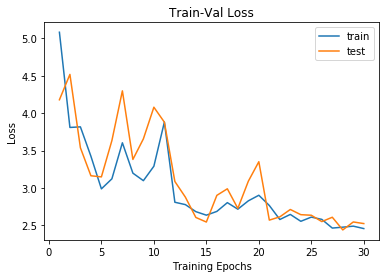

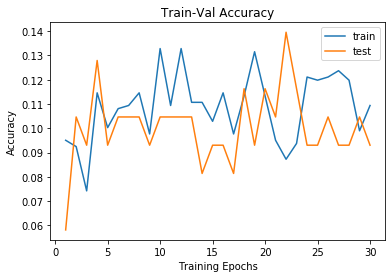

In [616]:
trainutils.plot_loss(loss_hist, metric_hist)